In [1]:
#####Note:run in python2######
#to show the effect of shuffling data
#ARCHITECTURE 
# ONE CNN LAYER WITH KERNEL SIZE(5,5) AND 32 SUCH KERNELS
# ONE UNRAVELING MATRIX
# ONE FULLY CONNECTED LAYER TO OUTPUT USING SOFTMAX
# TRAIN DATA ONLY 100 SAMPLES USED AND TESTED AGAINST ONLY 30 SAMPLES

import math
import numpy as np
import sys
from PIL import Image
import matplotlib.pyplot as plt 

np.random.seed(69)
########################################################################
#initialise all parameters fo CNN


In [2]:
#CONVOLUTION NEURAL NETWORK CONVOLUTION FUNCTION

#FORWARD NETWORK
def outdim(N,M,s,pad):
    if pad =='valid':
        return (N-M)/s+1
    return N

def init(img,L,M,filt_num1,filt_num2):

    kernelMatrix=[np.random.normal(1e-4,1,(filt_num1,5, 5 ,img.shape[-1])),np.random.normal(1e-4,1,(filt_num2,5,5,filt_num1))] 
    biasMatrix  =[]
    biasMatrix.append(np.random.normal(0,0.1,(kernelMatrix[0].shape[0])))
    biasMatrix.append(np.random.normal(0,0.1,(kernelMatrix[1].shape[0])))
    WMatrix=1.0/M*np.random.normal(0,1,(L,M))

    return kernelMatrix,biasMatrix,WMatrix



def exceptions(img,conv_filter):

    if len(img.shape) > 2 or len(conv_filter.shape) > 3: # Check if number of image channels matches the filter depth.
        if img.shape[-1] != conv_filter.shape[-1]:
            print("Error: Number of channels in both image and filter must match.")
            sys.exit()

#a function to pad the input with zeros along column and rows

def pad_input(img, Mrow, Mcol, stride):

    N = img.shape[0]

    ##padding along rows
    p1 = int(math.ceil(((img.shape[0]-1)*(stride[0]) + Mrow -img.shape[0])/2))
    for i in range(0,p1):
        img=np.vstack((np.zeros((1,img.shape[1],img.shape[2])),img))
        img=np.vstack((img,np.zeros((1,img.shape[1],img.shape[2]))))

    #padding along column
    p2 = int(math.ceil(((img.shape[1]-1)*(stride[1]) + Mcol -img.shape[1])/2))
    for i in range(0,p2):
        img=np.hstack((np.zeros((img.shape[0],1,img.shape[2])),img))
        img=np.hstack((img,np.zeros((img.shape[0],1,img.shape[2]))))

    return img

def apply_activationCONV(Activation_function,inp):
    
    #activation functions
    if Activation_function == "relu":
        return np.where(inp<0,0,inp)
    elif Activation_function == "tanh":
        return np.tanh(inp)
    elif Activation_function == "sigmoid":
        return 1.0/(1+np.exp(-1.0*inp))
    else:
        return inp


def conv(img, conv_filter, padding, stride, Activation_function, bias):

    # print img.shape
    if padding == 'same':

        img = np.array(pad_input(img,conv_filter.shape[1],conv_filter.shape[2],stride))
        # print img.shape

    # see for exceptions
    
    exceptions(img,conv_filter)
    # An empty feature map to hold the output of convolving the filter(s) with the image.
    preconv = np.zeros((   (img.shape[0]-conv_filter.shape[1])/stride[0] + 1 , 
                                (img.shape[1]-conv_filter.shape[2])/stride[1] + 1 , conv_filter.shape[0] ))
    # An empty feature map to hold the output of convolving the filter(s) with the image.
    feature_maps = np.zeros((   (img.shape[0]-conv_filter.shape[1])/stride[0] + 1 , 
                                (img.shape[1]-conv_filter.shape[2])/stride[1] + 1 , conv_filter.shape[0] ))
    # Convolving the image by the filter(s).
    for filter_num in range(conv_filter.shape[0]):

        curr_filter = conv_filter[filter_num, :]

        filter_sizeRow = curr_filter.shape[0]

        filter_sizeCol = curr_filter.shape[1]

        #Applying the convolution operation.
        r2=0
        for r in np.arange(0,img.shape[0]-filter_sizeRow+1,stride[0]):
            c2=0
            for c in np.arange(0,img.shape[1]-filter_sizeCol+1,stride[1]):
                #Region required
                curr_region = img[r:r+filter_sizeRow,c:c+filter_sizeCol,:]
                #Element-wise multipliplication between the current region and the filter.
                curr_result = curr_region * curr_filter
                #Summing the result of multiplication.
                feature_maps[r2,c2, filter_num] =np.sum(curr_result)
                c2=c2+1
            r2=r2+1
        preconv[:,:,filter_num]=feature_maps[:,:,filter_num]+bias[filter_num]
        feature_maps[:,:,filter_num]=apply_activationCONV(Activation_function,preconv[:,:,filter_num])
    
    return feature_maps,preconv # Returning all feature maps.



In [3]:
#below is the pooling function

In [4]:
#pooling functions
#ker_shape=(2,2)
def pool(img,ker_shape,stride):
    ker_rows = ker_shape[0]
    ker_cols = ker_shape[1]
    i=0
    j=0
    k=0
    l=0
    mask = np.zeros(img.shape)
    new_shape = (int((img.shape[0]-ker_rows)/stride[0])+1,int((img.shape[1]-ker_cols)/stride[1])+1)
    out = np.zeros(new_shape)
    while(1):
        if ker_rows+i > img.shape[0]:
            break
        else:
            while(1):
                if ker_cols+j > img.shape[1]: ### we reached the end of set corresponding to the current row
                    j=0
                    l=0
                    i=i+stride[0]
                    k=k+1
                    break
                else:
                    temp = img[i:ker_rows+i,j:ker_cols+j]
                    temp1 = temp.reshape(-1,1)
                    temp2 = mask[i:ker_rows+i,j:ker_cols+j]
                    temp2 = temp2.reshape(-1,1)
                    temp2[np.argmax(temp1)] = 1
                    mask[i:ker_rows+i,j:ker_cols+j] = temp2.reshape((ker_rows,ker_cols))
                    out[k][l] = np.max(temp)
                    j=j+stride[1]
                    l=l+1
    return (out,mask)

def pool_volume(img,ker_shape,stride):
    depth = img.shape[2]
    temp1 = []
    masks = []
    i=0
    while(i<depth):
        temp,mask = pool(img[:,:,i],ker_shape,stride)
        temp1.append(temp)
        masks.append(mask)
        i=i+1
    temp1 = np.array(temp1)
    masks = np.array(masks)
    shape = temp1.shape
    shape1 = masks.shape
    temp1 = temp1.reshape(shape[0],shape[1],shape[2])
    masks = masks.reshape(shape1[0],shape1[1],shape1[2])
    output_volume = np.zeros((shape[1],shape[2],shape[0]))
    masks_volume = np.zeros((shape1[1],shape1[2],shape1[0]))
    for i in range(depth):
        output_volume[:,:,i] = temp1[i,:,:]
        masks_volume[:,:,i] = masks[i,:,:] 
    return (output_volume,masks_volume)

In [5]:
##########

#unraveling function
def unraveling(inp,WMatrix):

    flatten = np.array(inp.flatten()).reshape(-1,1)

    return np.array(np.matmul(WMatrix,flatten))



##########
#display the output of the layers

def display(feature_maps,poolOut,NoOfConv,kernelMatrix):
    
    print('Displaying output per channel of a given volume')

    for i in range(0,NoOfConv):
        print('LAYER: '+str(i+1))
        print('Kenels per layer shape'+str((kernelMatrix[i]).shape))
        print('Convolution output'+str((feature_maps[i]).shape))
        print('Pooling output'+str((poolOut[i]).shape))
        for j in range(0,feature_maps[i].shape[2]):
            plt.title('Layer:'+str(i+1)+' Activation_maps[:,:,'+str(j)+']')
            plt.imshow((feature_maps[i])[:,:,j],cmap="gray")
            plt.show()
            plt.title('After pooling PoolOut[:,:,'+str(j)+']')
            plt.imshow((poolOut[i])[:,:,j],cmap="gray")
            plt.show()

In [6]:
#mlp forward pass
#layer
def layer(w,x,b):
    out = np.matmul(w,x)+b
    return out

def apply_activationMLP(Activation_function,inp):
    
    #activation functions
    if Activation_function == "relu":
        return np.where(inp<0,0,inp)
    elif Activation_function == "tanh":
        return np.tanh(inp)
    elif Activation_function == "sigmoid":
        return 1.0/(1+np.exp(-1.0*inp))
    elif Activation_function == "softmax":
        return (1.0/(np.sum(np.exp(inp),axis=0)))*(np.exp(inp))

#forward path
def forward_path(X,W,b,Activation_function='softmax'):

   
    z=apply_activationMLP(Activation_function,np.array(layer(W,X,b)))

    out = (np.array(z))

    return out

In [7]:
######################################
#Backpropagation
#convolution backprop
#derivative of relu

def conv_backprop(arr,ker):
    ker_rows = ker.shape[0]
    ker_cols = ker.shape[1]
    ker = ker.reshape(ker_rows,ker_cols,1)
    i=0
    j=0
    k=0
    l=0
    new_shape = (int((arr.shape[0]-ker_rows))+1,int((arr.shape[1]-ker_cols))+1,arr.shape[2])
    out = np.zeros(new_shape)
    while(1):
        if ker_rows+i > arr.shape[0]:
            break
        else:
            while(1):
                if ker_cols+j > arr.shape[1]: ### we reached the end of set corresponding to the current row
                    j=0
                    l=0
                    i=i+1
                    k=k+1
                    break
                else:
                    temp = arr[i:ker_rows+i,j:ker_cols+j,:]
                    tmp = np.sum(temp*ker,axis=1)
                    out[k][l] = np.sum(tmp,axis=0)
                    j=j+1
                    l=l+1
    return out

def conv_backprop_volume(arr,kernel):
    depth  = kernel.shape[2]
    temp1  = []
    i=0
    while(i<depth):
        temp = conv_backprop(arr,kernel[:,:,i])
        temp1.append(temp)
        i=i+1
    temp1 = np.array(temp1)
    return temp1


def der_relu(inp):
    return np.where(inp<0,0,1)

def ConvBackprop(dy,z,W,M,x,pool1,preconv2,pool2,mask_inp2,filt2):
    #MLP LAYER
    dW=np.matmul(dy,z.T)
    db=dy.reshape(len(dy),1)
    #Unraveling layer
    #let us call M as the unraveling matrix
    s=np.matmul(W.T,dy)

    dM=np.matmul(s,x.T)
    #Convolutional layer
    #gradient with respect to flattened array of pool2 
    gradf = np.matmul(M.T,s)

    #found the gradient wrt the flattened vector reshaping it to pooling layer size

    gradPool2 = gradf.reshape((pool2.shape[0],pool2.shape[1],pool2.shape[2]))  

    ####
    #comvolutional layer backprop
    #following the architecture in sildes and taking the pooling function as average pooling
    gradConv2 = np.repeat(gradPool2 ,2,axis=0)
    gradConv2 = np.repeat(gradConv2,2,axis=1)
    #multiplication with derivative of relu
    gradConv2 = mask_inp2*gradConv2*der_relu(preconv2)
    #since padding is 'same' according to architecture

    #pool1Rot=np.rot90(pad_input(pool1,filt2.shape[1],filt2.shape[2],(1,1)),2,(0,1))
    pool1Rot=pad_input(pool1,filt2.shape[1],filt2.shape[2],(1,1))
    bias=np.zeros(filt2.shape[0]) 

    #function parameters
    #conv(img, conv_filter, padding, stride, Activation_function, bias)
    
    dfilt2 = conv_backprop_volume(pool1Rot,gradConv2)
    
    dbias2=np.sum(gradConv2,axis=(0,1)).reshape(-1,1)
    
    return dW,db,dM,dfilt2,dbias2



In [8]:
#only to import data
from keras import backend as K
import keras
from keras.datasets import mnist

np.random.seed(69)
################################
# Training parameters
batch_size = 50
num_classes = 10
epochs = 30
learningRate=0.001

################################

#import data

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(trainDataX, trainLabelY_num), (testDataX, testLabelY_num) = mnist.load_data()

trainDataX = trainDataX.reshape(trainDataX.shape[0], img_rows, img_cols, 1)
testDataX = testDataX.reshape(testDataX.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

trainDataX = trainDataX.astype('float32')

testDataX = testDataX.astype('float32')
trainDataX /= 255.0
testDataX /= 255.0
print('trainDataX shape:', trainDataX.shape)
print(trainDataX.shape[0], 'train samples')
print(testDataX.shape[0], 'test samples')

# convert class vectors to binary class matrices
trainLabelY = keras.utils.to_categorical(trainLabelY_num, num_classes)
print(trainLabelY_num.shape, 'train labels')
testLabelY = keras.utils.to_categorical(testLabelY_num, num_classes)
print(testLabelY.shape[0], 'train labels')

Using TensorFlow backend.


('trainDataX shape:', (60000, 28, 28, 1))
(60000, 'train samples')
(10000, 'test samples')
((60000,), 'train labels')
(10000, 'train labels')


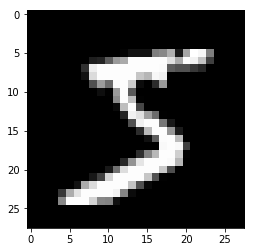

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [9]:
x_train = []
y_train = []

x_test = []
y_test = []
for i in range(10):
    t = np.argwhere(trainLabelY_num == i)
    x_train.append(trainDataX[t[0:10]])
    y_train.append(trainLabelY[t[0:10]])
    x_test.append(testDataX[t[20:23]])
    y_test.append(testLabelY[t[20:23]])
    

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

x_train = x_train.reshape(100,28,28,1)
y_train = y_train.reshape(100,10)
y_test = y_test.reshape(30,10)
x_test = x_test.reshape(30,28,28,1)

plt.imshow(x_train[50,:,:,0],cmap="gray")
plt.show()
print(y_train[50,:])

In [10]:
#initialisation of initial weights
### initialisations
kernel1 = np.random.normal(0,1,(32,5,5,1))
bias1   = np.random.normal(0,1,(32,1))
WMatrix = np.random.uniform(0,1e-3,(1024,14*14*32))
W = np.random.uniform(0,1e-3,(10,1024))
b = np.random.uniform(0,1e-3,(10,1))

In [11]:
#Training of neural network starts 
#This is example for stochastic gradient descent

def validation(x_test,kernel1,bias1,WMatrix,W,b):
    loss=0
    for i in range(0,x_test.shape[0]):
            conv_out1,preconv1 = conv(x_train[j+k,:,:,:],kernel1,'same',(5,5),'relu',bias1)
            pool_out1,mask_inp1 = pool_volume(conv_out1,(2,2),(2,2))

            x = pool_out1.reshape(-1,1)
            z = unraveling(x,WMatrix).reshape(-1,1)
            y = forward_path(z,W,b,"softmax").reshape(-1,1)
            loss = loss -np.log(y[np.argmax(y_train[j+k:,])])
    return loss

In [12]:
print('Batch size: '+str(batch_size))

#for shuffling data
from sklearn.utils import shuffle
Trainloss = []
Validationloss=[]
for i in range(epochs):
### forward pass
    print('Epoch:    '+str(i))
    loss=0
    #shuffling the data
    (x_train,y_train) = shuffle(x_train,y_train,random_state = 42)
    for j in np.arange(0,x_train.shape[0],batch_size):

        dW = np.zeros(W.shape)
        db = np.zeros(b.shape)
        dWMatrix = np.zeros(WMatrix.shape)
        dkernel1  = np.zeros(kernel1.shape)
        dbias1  = np.zeros(bias1.shape)
        for k in range(0,batch_size):
            bias1=bias1.reshape((-1,1))
            conv_out1,preconv1 = conv(x_train[j+k,:,:,:],kernel1,'same',(5,5),'relu',bias1)
            pool_out1,mask_inp1 = pool_volume(conv_out1,(2,2),(2,2))
            # conv_out2 = conv_volume(padd_inp2,W_conv2,(1,1),"relu")
            # pool_out2,mask_inp2 = pool_volume(conv_out2,(2,2),(2,2))

            x = pool_out1.reshape(-1,1)
            z = unraveling(x,WMatrix).reshape(-1,1)
            y = forward_path(z,W,b,"softmax").reshape(-1,1)
            loss = loss -np.log(y[np.argmax(y_train[j+k:,])])

            ### backprop starts here
            dy = (y-y_train[j+k,:].reshape(-1,1)).reshape(-1,1)

            #taking activation funtion as softmax
            #ConvBackprop(dy,z,W,x,pool1,preconv2,pool2,mask_inp2,filt2):
            a,b,c,d,e=ConvBackprop(dy,z,W,WMatrix,x,x_train[j+k,:,:,:]
                                                  ,preconv1,pool_out1,mask_inp1,kernel1)
            
            dW=dW+a
            db=db+b
            dWMatrix=dWMatrix+c
            dkernel1=dkernel1+d
            dbias1=dbias1+e

    
        kernel1 = kernel1 - learningRate*dkernel1
        bias1   = bias1 - learningRate*dbias1
        W   = W - learningRate*dW
        b   = b - learningRate*db
        WMatrix = WMatrix - learningRate*dWMatrix
    vloss = validation(x_test,kernel1,bias1,WMatrix,W,b)
    print('Loss:'+str(loss)+'    Validation:'+str(vloss))
    Trainloss.append(loss)
    Validationloss.append(vloss)

Batch size: 50
Epoch:    0
Loss:[298.99808384]    Validation:[73.37261286]
Epoch:    1
Loss:[392.11294905]    Validation:[101.78768231]
Epoch:    2
Loss:[242.0702027]    Validation:[85.77326844]
Epoch:    3
Loss:[254.87127204]    Validation:[57.06816914]
Epoch:    4
Loss:[246.18820599]    Validation:[95.1475527]
Epoch:    5
Loss:[230.38913348]    Validation:[94.62171918]
Epoch:    6
Loss:[231.06606051]    Validation:[110.59441752]
Epoch:    7
Loss:[265.14365656]    Validation:[203.20600307]
Epoch:    8
Loss:[240.76919486]    Validation:[94.52998194]
Epoch:    9
Loss:[234.62937726]    Validation:[99.47963733]
Epoch:    10
Loss:[221.12695904]    Validation:[97.69646603]
Epoch:    11
Loss:[227.02358729]    Validation:[96.08747427]
Epoch:    12
Loss:[229.12691663]    Validation:[92.14929004]
Epoch:    13
Loss:[227.57941443]    Validation:[97.57007333]
Epoch:    14
Loss:[222.33381916]    Validation:[100.48625077]
Epoch:    15
Loss:[225.13616689]    Validation:[95.98508099]
Epoch:    16
Loss

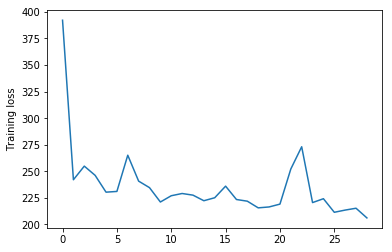

In [19]:
#plotting the training loss
import matplotlib.pyplot as plt
import numpy as np
x=np.array(Trainloss)
plt.plot(x[1:30])
plt.ylabel('Training loss')
plt.show()
#due to shuffling there is some zigzag nature in the training loss as opposed to the without shuffle training loss
#graph which smoothly falls off
#indicating that shuffle is better in generalising

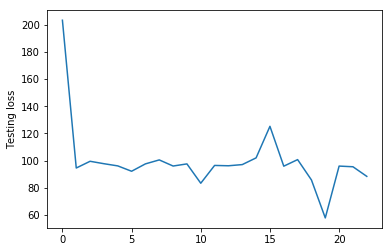

In [28]:
#plotting the testing loss
import matplotlib.pyplot as plt
import numpy as np
x=np.array(Validationloss)
plt.plot(x[7:30])
plt.ylabel('Testing loss')
plt.show()
#but if we observe testing loss is being constant and better condition than without shuffle which is
#trying to generalise the model

In [13]:
def predict(y):
    return np.argmax(y)

yvect=[]
y_trurevect=[]

for i in range(0,x_train.shape[0]):
    conv_out1,preconv1 = conv(x_train[i,:,:,:],kernel1,'same',(5,5),'relu',bias1)
    pool_out1,mask_inp1 = pool_volume(conv_out1,(2,2),(2,2))
    x = pool_out1.reshape(-1,1)
    z = unraveling(x,WMatrix).reshape(-1,1)
    y = forward_path(z,W,b,"softmax").reshape(-1,1)
    yvect.append(predict(y))
    y_trurevect.append(predict(y_train[i,:]))

In [14]:
#predicting train accuracy
from sklearn.metrics import accuracy_score

print(accuracy_score(y_trurevect, yvect))

0.28


In [15]:

yvect=[]
y_trurevect=[]

for i in range(0,x_test.shape[0]):
    conv_out1,preconv1 = conv(x_test[i,:,:,:],kernel1,'same',(5,5),'relu',bias1)
    pool_out1,mask_inp1 = pool_volume(conv_out1,(2,2),(2,2))
    x = pool_out1.reshape(-1,1)
    z = unraveling(x,WMatrix).reshape(-1,1)
    y = forward_path(z,W,b,"softmax").reshape(-1,1)
    yvect.append(predict(y))
    y_trurevect.append(predict(y_test[i,:]))

In [16]:
#predicting test accuracy
print(accuracy_score(y_trurevect, yvect))

0.1
